In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled)


In [2]:
# Seed for reproduciblity
np.random.seed(42)

In [3]:
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2015-11-08 22:51:14--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Server file no newer than local file ‘mnist.pkl.gz’ -- not retrieving.



In [4]:
train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

In [5]:
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

In [6]:
# We need to reshape from a 1D feature vector to a 1 channel 2D image.
# Then we apply 3 convolutional filters with 3x3 kernel size.
l_in = lasagne.layers.InputLayer((None, 784))

l_shape = lasagne.layers.ReshapeLayer(l_in, (-1, 1, 28, 28))

l_conv = lasagne.layers.Conv2DLayer(l_shape, num_filters=3, filter_size=3, pad=1)

l_out = lasagne.layers.DenseLayer(l_conv,
                                  num_units=10,
                                  nonlinearity=lasagne.nonlinearities.softmax)


In [7]:
# Compile and train the network.
# Accuracy is much better than the single layer network, despite the small number of filters.
X_sym = T.matrix()
y_sym = T.ivector()

output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))

acc = T.mean(T.eq(pred, y_sym))

params = lasagne.layers.get_all_params(l_out)
grad = T.grad(loss, params)
updates = lasagne.updates.adam(grad, params, learning_rate=0.005)

f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])
f_predict = theano.function([X_sym], pred)

BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

for epoch in range(5):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch 0, Train (val) loss 0.237 (0.133) ratio 0.559
Train (val) accuracy 0.933 (0.965)
Epoch 1, Train (val) loss 0.106 (0.125) ratio 1.180
Train (val) accuracy 0.968 (0.966)
Epoch 2, Train (val) loss 0.085 (0.105) ratio 1.229
Train (val) accuracy 0.975 (0.971)
Epoch 3, Train (val) loss 0.075 (0.123) ratio 1.642
Train (val) accuracy 0.977 (0.971)
Epoch 4, Train (val) loss 0.063 (0.105) ratio 1.681
Train (val) accuracy 0.979 (0.972)


In [8]:
# We can look at the output after the convolutional layer 
filtered = lasagne.layers.get_output(l_conv, X_sym)
f_filter = theano.function([X_sym], filtered)

In [9]:
# Filter the first few training examples
im = f_filter(X_train[:10])
print(im.shape)

(10, 3, 28, 28)


In [10]:
# Rearrange dimension so we can plot the result as RGB images
im = np.rollaxis(np.rollaxis(im, 3, 1), 3, 1)

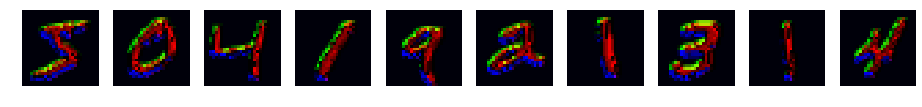

In [11]:
# We can see that each filter seems different features in the images
# ie horizontal / diagonal / vertical segments
plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(im[i], interpolation='nearest')
    plt.axis('off')